In [33]:
# -----------------------------------------------------------
# 1) Import des bibliothèques nécessaires
# -----------------------------------------------------------
from pymatgen.ext.matproj import MPRester  
from pymatgen.io.cif import CifWriter  
from IPython.display import FileLink  
from pymatgen.electronic_structure.plotter import BSPlotter  
import numpy as np  
import matplotlib.pyplot as plt  
from pymatgen.electronic_structure.core import Spin
import math
from scipy import integrate
# -----------------------------------------------------------
# 2) Récupération des données depuis Materials Project
# -----------------------------------------------------------
with MPRester("n58KMF7umZMAJXouXDJc0vORWlcEfEsD") as m:
    # Récupération de la structure
    prim_struc = m.get_structure_by_material_id("mp-15794")
    # Récupération de la structure ph-dos
    ph_dos = m.get_phonon_dos_by_material_id("mp-15794")

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Chaleur spécifique molaire

In [34]:
# -----------------------------------------------------------
# 3) Données
# -----------------------------------------------------------
temperatures = np.arange(0,1000,5)
R = 8.314
Nat = len(prim_struc)
ph_cv = np.array([ph_dos.cv(temperatures[i]) for i in range(len(temperatures))])/(3*Nat*R)
print(len(ph_cv))

200


In [35]:
# -----------------------------------------------------------
# 4) Chleur spécifique selon Einstein
# -----------------------------------------------------------


# Définition de la fonction Einstein avec gestion des cas limites
def einstein_cv(theta, T):
    # Si T est nul ou quasi nul, on renvoie NaN pour indiquer l'impossibilité du calcul
    if T <= 1e-12:
        return float('nan')
    
    # Calcul de l'exponentielle
    exp_val = math.exp(theta / T)
    
    # Si exp_val - 1 est trop petit, le dénominateur (exp_val - 1)^2 sera quasi nul
    diff = exp_val - 1.0
    if abs(diff) < 1e-12:
        return float('nan')
    
    # Formule du modèle d'Einstein
    return ((theta / T)**2) * exp_val / (diff**2)

# Supposons que 'temperatures' et 'ph_cv' soient déjà définis et de même longueur
# On va chercher la température d'Einstein (theta_e) minimisant l'erreur quadratique
meilleure_erreur = float('inf')
meilleure_theta = 0

for theta_candidat in range(1, 1000):
    erreur_cumulee = 0.0
    nb_valeurs_valides = 0
    
    for i in range(len(temperatures)):
        cv_pred = einstein_cv(theta_candidat, temperatures[i])
        # On saute les valeurs NaN (par ex. si T=0 ou exponentielle ~ 1)
        if not math.isnan(cv_pred):
            mse = (cv_pred - ph_cv[i])**2
            erreur_cumulee += mse
            nb_valeurs_valides += 1
    
    # On ne compare l'erreur que s'il y a des points valides
    if nb_valeurs_valides > 0:
        # On peut normaliser l'erreur par nb_valeurs_valides si on veut
        # pour comparer de façon cohérente (au lieu de l'erreur cumulée brute)
        erreur_moyenne = erreur_cumulee / nb_valeurs_valides
        
        if erreur_moyenne < meilleure_erreur:
            meilleure_erreur = erreur_moyenne
            meilleure_theta = theta_candidat

# Une fois la meilleure theta trouvée, on calcule les valeurs de CV Einstein
cv_einstein = []
for temp in temperatures:
    val = einstein_cv(meilleure_theta, temp)
    # On choisit, par exemple, de remplacer les valeurs NaN par 0.0 (ou un autre choix)
    if math.isnan(val):
        val = 0.0
    cv_einstein.append(val)

print("Température d'Einstein minimisant l'erreur (MSE) :", meilleure_theta, "K")


Température d'Einstein minimisant l'erreur (MSE) : 212 K


In [36]:
# -----------------------------------------------------------
# 5) Chleur spécifique selon Debye
# -----------------------------------------------------------


# Définition de la fonction d'intégration pour le modèle de Debye
def debye_integrand(x):
    """Calcul de la fonction f(x) = x^4 * exp(x) / (exp(x) - 1)^2."""
    return (x**4) * math.exp(x) / (math.exp(x) - 1)**2

# Modèle de capacité thermique de Debye
def debye_cv(theta_debye, temperature):
    """
    Calcule la capacité thermique selon le modèle de Debye :
    CV = 3 * (T / theta_debye)^3 * intégrale de 0 à theta_debye/T de f(x) dx
    """
    # Gérer les cas limites pour éviter les divisions par zéro ou bornes d'intégration invalides.
    if temperature <= 1e-12:
        # Si T est trop proche de zéro, on retourne NaN ou 0 en fonction de l'option désirée
        return float('nan')
    
    # Calcul de la borne d'intégration
    borne = theta_debye / temperature

    # Si la borne est infinie ou trop grande, l'intégrale peut devenir difficile à calculer
    if borne > 1e6:  # Seuil arbitraire, à adapter si besoin
        # Dans le modèle de Debye, si borne -> inf, on peut approximer l'intégrale.
        # Mais ici, on simplifie en indiquant que c'est un cas limite
        return float('nan')
    
    # On tente l'intégration numérique
    try:
        val_integree, _ = integrate.quad(debye_integrand, 0, borne)
    except Exception:
        # En cas d'erreur de convergence, on renvoie NaN (ou une valeur par défaut)
        return float('nan')
    
    # Formule finale
    return 3.0 * ((temperature / theta_debye)**3) * val_integree

# On imagine que temperatures et ph_cv sont déjà définis et de même longueur.
# Recherchons le theta_debye minimisant l'erreur quadratique.
meilleure_erreur = float('inf')
meilleur_theta = 0

for theta_candidat in range(1, 1000):
    erreur_accumulee = 0.0
    nb_points_valides = 0
    
    # Calcul de l'erreur sur l'ensemble des points expérimentaux
    for i in range(1, 200):
        prediction = debye_cv(theta_candidat, temperatures[i])
        
        # On ignore les prédictions NaN (cas limites non définis)
        if not math.isnan(prediction):
            diff = prediction - ph_cv[i]
            erreur_accumulee += diff**2
            nb_points_valides += 1
    
    # Mise à jour si on a un nombre de points valides et une erreur minimale
    if nb_points_valides > 0:
        mse = erreur_accumulee / nb_points_valides
        if mse < meilleure_erreur:
            meilleure_erreur = mse
            meilleur_theta = theta_candidat

# Une fois la meilleure valeur trouvée, on construit la liste des capacités
capacites_debye = []
for temp in temperatures:
    val_cv = debye_cv(meilleur_theta, temp)
    # On peut remplacer les NaN par 0.0, ou toute autre valeur
    if math.isnan(val_cv):
        val_cv = 0.0
    capacites_debye.append(val_cv)

print("Température de Debye minimisant l'erreur au sens des moindres carrés :", meilleur_theta, "K")

Température de Debye minimisant l'erreur au sens des moindres carrés : 286 K


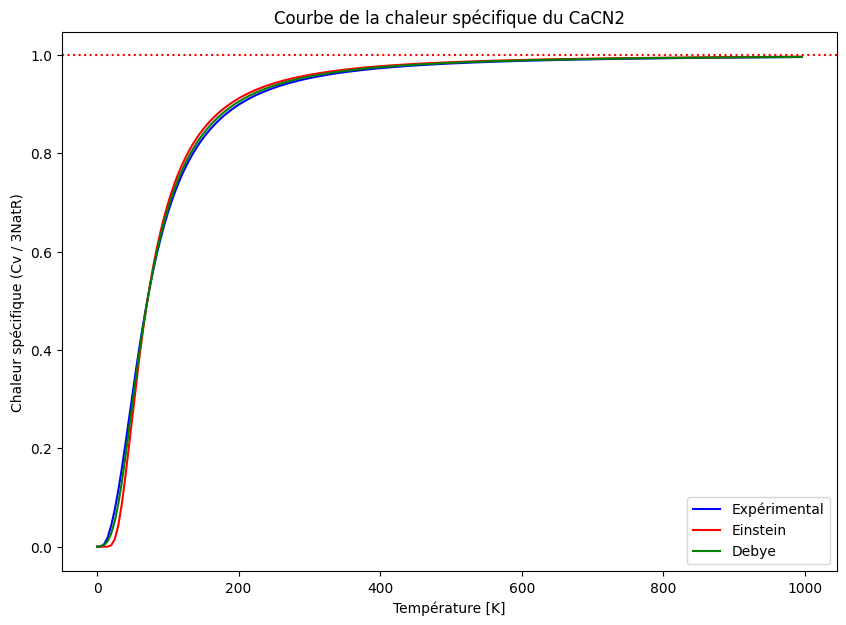

In [37]:
# -----------------------------------------------------------
# 6) Représentation graphique 
# -----------------------------------------------------------
# Création d'une figure
plt.figure(figsize=(10, 7))

# Tracé des courbes Expérimentale, Einstein et Debye
plt.plot(temperatures, ph_cv, label="Expérimental", color="blue")
plt.plot(temperatures, cv_einstein, label="Einstein", color="red")
plt.plot(temperatures, capacites_debye, label="Debye", color="green")

# Ajout d'une ligne horizontale en pointillés à y=1
plt.axhline(y=1.0, color='red', linestyle='dotted')

# Titres et légendes
plt.title("Courbe de la chaleur spécifique du CaCN2")
plt.xlabel("Température [K]")
plt.ylabel("Chaleur spécifique (Cv / 3NatR)")

plt.legend()
plt.show()


#  Densités d'états de phonons correspondantes

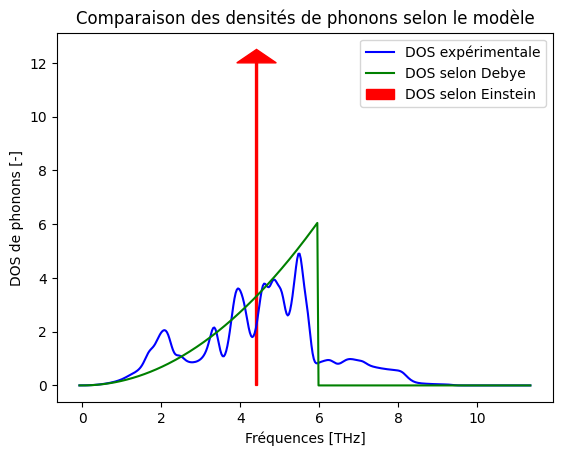

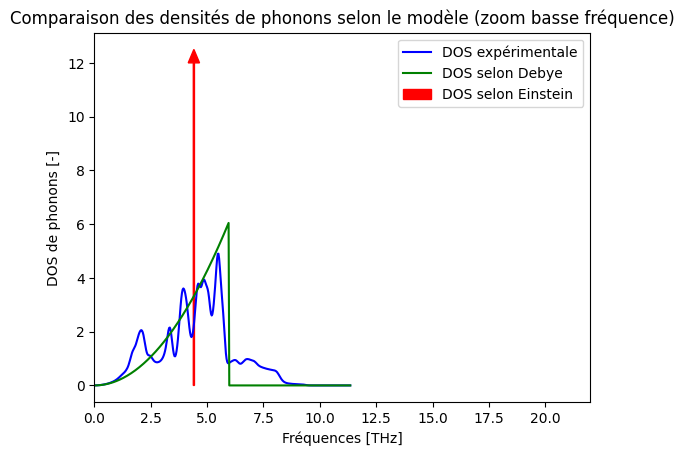

In [38]:
# Définition des constantes
KBOLTZ = 1.38e-23   # Constante de Boltzmann
HBAR = 1.055e-34    # Constante de Planck réduite

# Récupération des fréquences (freq) et de la DOS (densité) expérimentales
freq_exp = ph_dos.frequencies
dos_exp = ph_dos.densities

# Calcul de la pulsation d'Einstein (omega_e) et de sa fréquence (freq_e)
omega_einstein = (temp_e * KBOLTZ * 1e-12) / HBAR
freq_einstein = omega_einstein / (2.0 * np.pi)

# Calcul de la pulsation de coupure de Debye (omega_d) puis de la DOS Debye
omega_debye = (meilleur_theta * KBOLTZ * 1e-12) / HBAR
dos_debye = np.zeros(len(freq_exp))

# Construction du spectre de Debye sur l'intervalle de fréquences disponible
for idx, f_val in enumerate(freq_exp):
    om = 2.0 * np.pi * f_val
    if om < omega_debye:
        dos_debye[idx] = 9.0 * Nat * (om**2) / (omega_debye**3)

# Multiplication finale par 2π (facteur apparaissant dans la formule de DOS de Debye)
dos_debye *= (2.0 * np.pi)

# ====== Premier tracé : spectre complet ======
plt.plot(freq_exp, dos_exp, label="DOS expérimentale", color="blue")
plt.plot(freq_exp, dos_debye, label="DOS selon Debye", color="green")

# Ajout d'une flèche rouge à la fréquence d'Einstein
plt.arrow(
    freq_einstein, 0.0,          # Coordonnée (x, y) de départ
    0.0, 3.0 * Nat,              # Déplacement en x=0, y=3*Nat
    width=0.05, head_width=1.0,  # Largeur de la tige et de la tête de flèche
    head_length=0.5,             # Hauteur de la tête de flèche
    fc="red", ec="red", 
    label="DOS selon Einstein"
)

plt.title("Comparaison des densités de phonons selon le modèle")
plt.xlabel("Fréquences [THz]")
plt.ylabel("DOS de phonons [-]")
plt.legend()
plt.show()

# ====== Second tracé : zoom sur les basses fréquences ======
plt.plot(freq_exp, dos_exp, label="DOS expérimentale", color="blue")
plt.plot(freq_exp, dos_debye, label="DOS selon Debye", color="green")

# Même flèche rouge, mais avec une tête légèrement plus petite
plt.arrow(
    freq_einstein, 0.0,    
    0.0, 3.0 * Nat,        
    width=0.05, head_width=0.5, 
    head_length=0.5,        
    fc="red", ec="red",
    label="DOS selon Einstein"
)

plt.title("Comparaison des densités de phonons selon le modèle (zoom basse fréquence)")
plt.xlabel("Fréquences [THz]")
plt.ylabel("DOS de phonons [-]")
plt.xlim(0.0, 22.0)  # Zoom sur 0 à 22 THz
plt.legend()
plt.show()